# Imagenet Example

This notebook illustrates the use of the proposed in(n)vestigation methods on the imagenet dataset for a pretrained VGG16.

# Imports

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline  

import imp
import keras.backend
import keras.models
import numpy as np
import os

import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.optimizers import RMSprop

import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.tests.networks.base
import innvestigate.utils.visualizations as ivis

eutils = imp.load_source("utils", "./utils.py")
imgnetutils = imp.load_source("utils_mnist", "./utils_imagenet.py")

# Data

Get a few example images from the imagenet dataset.

In [ ]:
# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data()[:2]

# Build model

Load the pretrained VGG16 net with ReLUs.

In [2]:
# Parameter
netname = "vgg16"
pattern_type = "relu"

In [3]:
# Build Model

channels_first = keras.backend.image_data_format == "channels_first"

tmp = getattr(innvestigate.applications.imagenet, netname)
net = tmp(load_weights=True, load_patterns=pattern_type)
model = keras.models.Model(inputs=net["in"], outputs=net["out"])
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelp = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
modelp.compile(optimizer="adam", loss="categorical_crossentropy")

# Analysis¶

Use several methods to in(n)vestigate and visualize the learned classifier on a few example images.

In [4]:
color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

In [10]:
# Analysis.

patterns = net["patterns"]
# Methods we use and some properties.
methods = [
    # NAME             POSTPROCESSING     TITLE

    # Show input.
    ("input",                 {},                       imgnetutils.image,   "Input"),

    # Function
    ("gradient",              {},                       imgnetutils.graymap, "Gradient"),
    ("smoothgrad",            {"noise_scale": 50},      imgnetutils.graymap, "SmoothGrad"),
    ("integrated_gradients",  {},                       imgnetutils.graymap, ("Integrated", "Gradients")),

    # Signal
    ("deconvnet",             {},                       imgnetutils.bk_proj, "Deconvnet"),
    ("guided_backprop",       {},                       imgnetutils.bk_proj, ("Guided", "Backprop"),),
    ("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj, "PatterNet"),

    # Interaction
    ("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap, "Pattern", "Attribution"),
    ("lrp.z_baseline",        {},                       imgnetutils.heatmap, "LRP-Z"),
]

In [13]:
# Create analyzers.

analyzers = []
for method in methods:
    analyzers.append(innvestigate.create_analyzer(method[0], model, **method[1]))

# Create analysis.
analysis = np.zeros([len(images), len(analyzers), 224, 224, 3])
text = []
for i, (image, y) in enumerate(images):
    image = image[None, :, :, :]
    # Predict label.
    x = preprocess(image)
    prob = modelp.predict_on_batch(x)[0]
    y_hat = prob.argmax()

    text.append(("%s" % label_to_class_name[y],
                 "%.2f" % prob.max(),
                 "%s" % label_to_class_name[y_hat]))
    
    for aidx, analyzer in enumerate(analyzers):
        is_input_analyzer = methods[aidx][0] == "input"
        # Analyze.
        a = analyzer.analyze(image if is_input_analyzer else x)
        # Postprocess.
        if not np.all(np.isfinite(a)):
            print("Image %i, analysis of %s not finite: nan %s inf %s" %
                  (i, methods[aidx][3],
                   np.any(np.isnan(a)), np.any(np.isinf(a))))
        if not is_input_analyzer:
            a = postprocess(a)
        a = methods[aidx][2](a)
        analysis[i, aidx] = a[0]

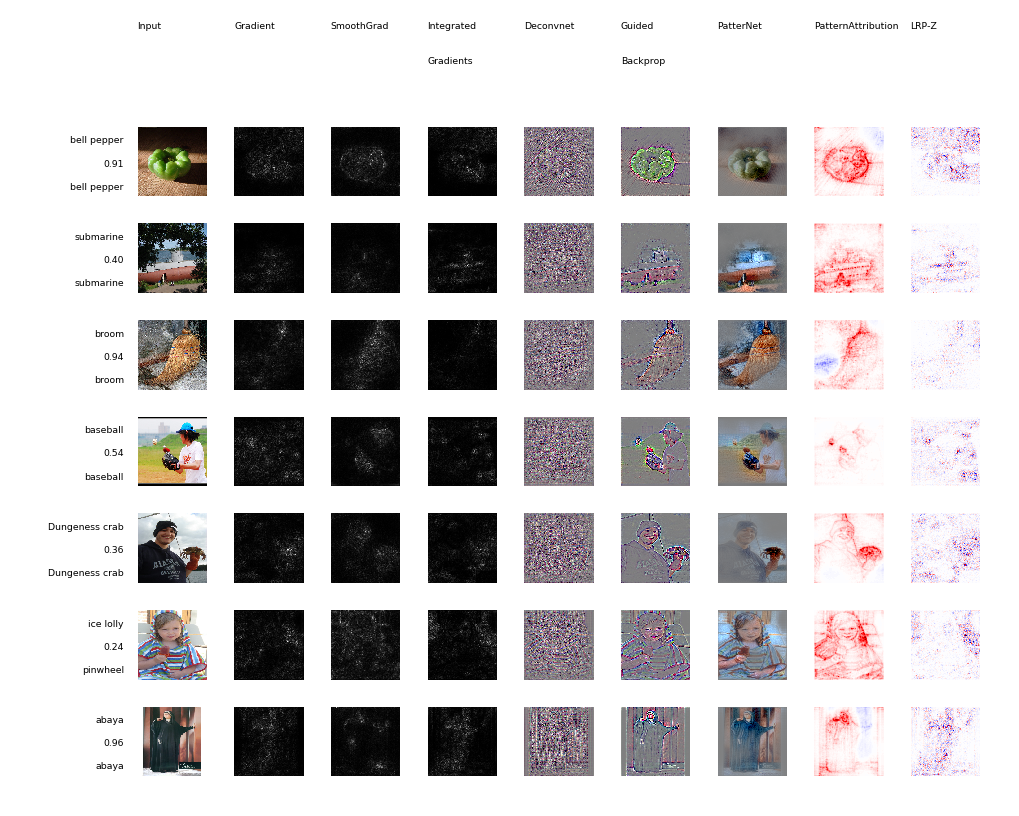

In [35]:
# Plot the analysis.

grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]  
row_labels = text
col_labels = [method[3] for method in methods]

eutils.plot_image_grid(grid, row_labels, col_labels,
                       row_label_offset=50,
                       col_label_offset=-50,
                       is_fontsize_adaptive=False,
                       usetex=False)